# Forecast of a Product's Sales

In [1]:
import os
while os.getcwd().endswith('/notebooks'):
    os.chdir('..')

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from src.preprocessing import preprocess
from src.utils import train_val_test_split, read_yaml
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from tqdm import tqdm

In [4]:
ID_PRODUTO = '25107-0'

In [5]:
data_path = 'data/base_estudo.csv'
cfg_path = 'cfg.yaml'
df = pd.read_csv(data_path, index_col=0)
df = preprocess(df, cfg_path)
df_unstacked = df.unstack()
cfg = read_yaml(cfg_path)
train_size=cfg['train_val_test_split']['train_size']
val_size=cfg['train_val_test_split']['val_size']
test_size=cfg['train_val_test_split']['test_size']
df_unstacked_split = train_val_test_split(
    df_unstacked,
    train_size=train_size,
    val_size=val_size,
    test_size=test_size,
)
df_split = {
    key: value.stack().sort_index()
    for key, value in df_unstacked_split.items()
}

/var/folders/bv/b2yqm8zs0ss3v3g31bbjz0840000gn/T/ipykernel_80956/2874407245.py:17: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  key: value.stack().sort_index()
/var/folders/bv/b2yqm8zs0ss3v3g31bbjz0840000gn/T/ipykernel_80956/2874407245.py:17: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  key: value.stack().sort_index()
/var/folders/bv/b2yqm8zs0ss3v3g31bbjz0840000gn/T/ipykernel_80956/2874407245.py:17: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details.

## Universal RFR Model

In [6]:
X_universal = {}
y_universal = {}
for period in ['train', 'val', 'test']:
    X_universal[period] = df_split[period].groupby('id_produto')['n_pedidos'].shift(range(1, 6))
    X_universal[period]['day_of_week'] = X_universal[period].index.get_level_values('data').dayofweek
    X_universal[period]['day_of_month'] = X_universal[period].index.get_level_values('data').day
    X_universal[period]['day_of_year'] = X_universal[period].index.get_level_values('data').dayofyear
    X_universal[period] = X_universal[period].dropna()
    y_universal[period] = df_split[period]['n_pedidos'].reindex(
        X_universal[period].index,
    )

In [7]:
X_universal['train']

n_pedidos_1  n_pedidos_2  n_pedidos_3  n_pedidos_4  \
data       id_produto                                                       
2022-07-08 15474-0             0.0          0.0          0.0          0.0   
           15475-0             0.0          0.0          0.0          5.0   
           15475-3         15960.0      86232.0       3360.0       9120.0   
           15476-0             0.0          0.0          0.0          0.0   
           15476-3         14544.0      33576.0       1920.0       2208.0   
...                            ...          ...          ...          ...   
2023-12-28 27525-0             0.0          0.0          0.0          0.0   
           28038-0             0.0          0.0          0.0          0.0   
           28039-0             0.0          0.0          0.0          0.0   
           28344-0             0.0          0.0          0.0          0.0   
           28438-0             0.0          0.0          0.0          0.0   

                       n_pedidos_5  day_of_week  day_of_month  day_of_year  
data       id_produto                                                       
2022-07-08 15474-0             0.0            4             8          189  
           15475-0             0.0            4             8          189  
           15475-3          1656.0            4             8          189  
           15476-0             0.0            4             8          189  
           15476-3           720.0            4             8          189  
...                            ...          ...           ...          ...  
2023-12-28 27525-0             0.0            3            28          362  
           28038-0             0.0            3            28          362  
           28039-0             0.0            3            28          362  
           28344-0             0.0            3            28          362  
           28438-0             0.0            3            28          362  

[77402 rows x 8 columns]

In [8]:
y_universal['train']

data        id_produto
2022-07-08  15474-0          0.0
            15475-0          0.0
            15475-3       4320.0
            15476-0          0.0
            15476-3       1200.0
                           ...  
2023-12-28  27525-0          0.0
            28038-0          0.0
            28039-0          0.0
            28344-0          0.0
            28438-0          0.0
Name: n_pedidos, Length: 77402, dtype: float64

In [9]:
param_grid = [
    {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'random_state': cfg['random_state'],
    }
    for n_estimators in [50, 100, 200]
    for max_depth in [10, None]
    for min_samples_split in [2, 5]
    for min_samples_leaf in [1, 2]
]
len(param_grid)

24

In [10]:
rfr_results = []
best_rfr_r2 = -float('inf')
for params in tqdm(param_grid):
    rfr = RandomForestRegressor(**params)
    rfr.fit(X_universal['train'].values, y_universal['train'].values)
    y_val_pred = rfr.predict(X_universal['val'].values)
    mae = mean_absolute_error(y_universal['val'].values, y_val_pred)
    rmse = root_mean_squared_error(y_universal['val'].values, y_val_pred)
    r2 = r2_score(y_universal['val'].values, y_val_pred)
    if best_rfr_r2 < r2:
        best_rfr_r2 = r2
        best_params = params
        best_rfr_model = rfr
    rfr_results.append({
        **params,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
    })
rfr_results_df = pd.DataFrame(rfr_results)

100%|██████████| 24/24 [03:45<00:00,  9.40s/it]


In [11]:
best_rfr_r2

0.2327080975129936

In [12]:
best_params

{'n_estimators': 100,
 'max_depth': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'random_state': 0}

In [13]:
rfr_results_df.sort_values('r2')

,n_estimators,max_depth,min_samples_split,min_samples_leaf,random_state,mae,rmse,r2
4,50,NaN,2,1,0,2554.442112,9204.427111,-0.010546
6,50,NaN,5,1,0,2537.137488,9088.793800,0.014685
12,100,NaN,2,1,0,2503.504658,8956.866272,0.043082
20,200,NaN,2,1,0,2500.969027,8913.414066,0.052344
14,100,NaN,5,1,0,2487.072588,8893.318312,0.056613
22,200,NaN,5,1,0,2482.050236,8847.005107,0.066413
5,50,NaN,2,2,0,2423.475934,8755.881601,0.085545
7,50,NaN,5,2,0,2421.861729,8752.670446,0.086216
13,100,NaN,2,2,0,2379.036574,8573.983448,0.123145
21,200,NaN,2,2,0,2381.214179,8553.182861,0.127395


In [14]:
y_universal_val_pred = best_rfr_model.predict(X_universal['val'].values)
y_universal_val_pred = pd.Series(y_universal_val_pred, index=y_universal['val'].index)

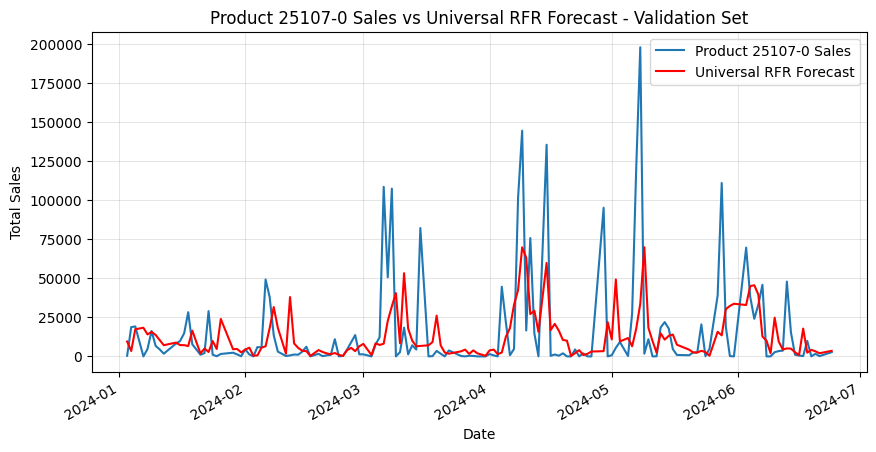

Universal RFR Model Evaluation for Product 25107-0 - Validation Set:
MAE: 16102.39
RMSE: 29459.75
R2: 0.15


In [50]:
plt.figure(figsize=(10, 5))
_y_val = y_universal['val'].xs(ID_PRODUTO, level='id_produto')
_y_val_pred = y_universal_val_pred.xs(ID_PRODUTO, level='id_produto')
_y_val.plot(label=f'Product {ID_PRODUTO} Sales')
_y_val_pred.plot(label='Universal RFR Forecast', color='red')
plt.legend()
plt.title(f'Product {ID_PRODUTO} Sales vs Universal RFR Forecast - Validation Set')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(c='k', alpha=0.1)
plt.show()

print(f'Universal RFR Model Evaluation for Product {ID_PRODUTO} - Validation Set:')
print(f'MAE: {mean_absolute_error(_y_val.values, _y_val_pred.values):.2f}')
print(f'RMSE: {root_mean_squared_error(_y_val.values, _y_val_pred.values):.2f}')
print(f'R2: {r2_score(_y_val.values, _y_val_pred.values):.2f}')

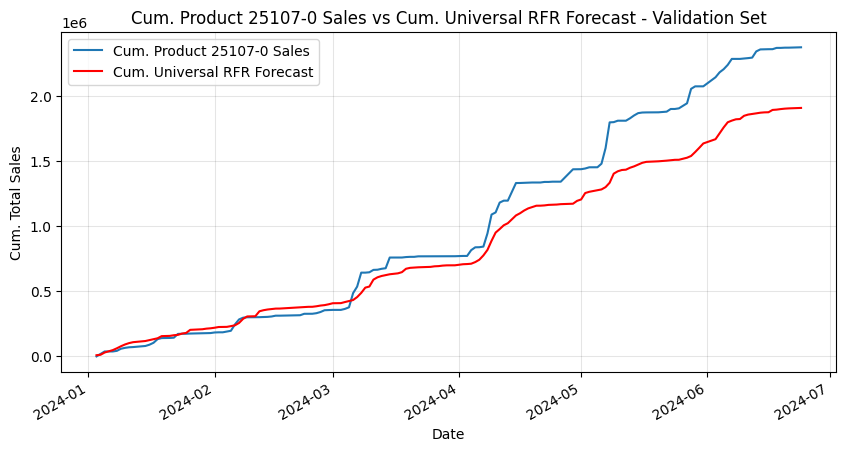

In [51]:
plt.figure(figsize=(10, 5))
_y_val = y_universal['val'].xs(ID_PRODUTO, level='id_produto')
_y_val_pred = y_universal_val_pred.xs(ID_PRODUTO, level='id_produto')
_y_val.cumsum().plot(label=f'Cum. Product {ID_PRODUTO} Sales')
_y_val_pred.cumsum().plot(label='Cum. Universal RFR Forecast', color='red')
plt.legend()
plt.title(f'Cum. Product {ID_PRODUTO} Sales vs Cum. Universal RFR Forecast - Validation Set')
plt.xlabel('Date')
plt.ylabel('Cum. Total Sales')
plt.grid(c='k', alpha=0.1)
plt.show()

In [17]:
y_universal_val_pred_total = y_universal_val_pred.groupby('data').sum()
y_universal_val_true_total = y_universal['val'].groupby('data').sum()

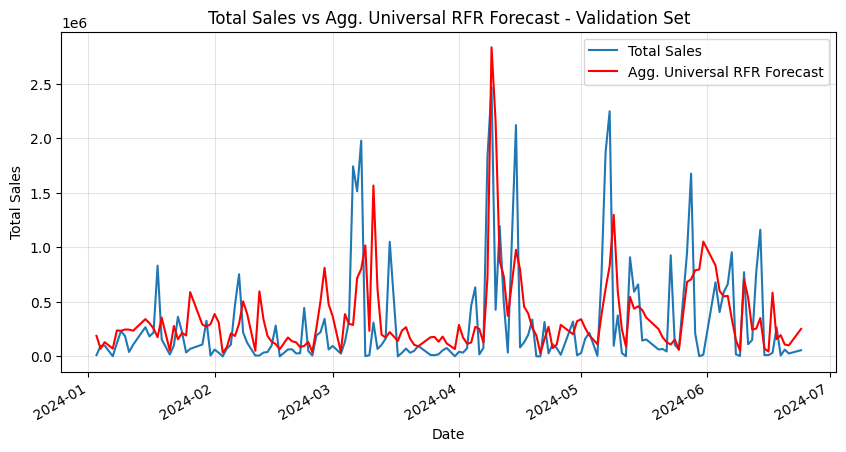

Agg. Universal RFR Model Evaluation - Validation Set:
RMSE: 444895.79
MAE: 290115.95
R2: 0.19


In [19]:
plt.figure(figsize=(10, 5))
y_universal_val_true_total.plot(label='Total Sales')
y_universal_val_pred_total.plot(label='Agg. Universal RFR Forecast', color='red')
plt.legend()
plt.title('Total Sales vs Agg. Universal RFR Forecast - Validation Set')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(c='k', alpha=0.1)
plt.show()

print('Agg. Universal RFR Model Evaluation - Validation Set:')
print(f"RMSE: {root_mean_squared_error(y_universal_val_true_total.values, y_universal_val_pred_total.values):.2f}")
print(f"MAE: {mean_absolute_error(y_universal_val_true_total.values, y_universal_val_pred_total.values):.2f}")
print(f"R2: {r2_score(y_universal_val_true_total.values, y_universal_val_pred_total.values):.2f}")

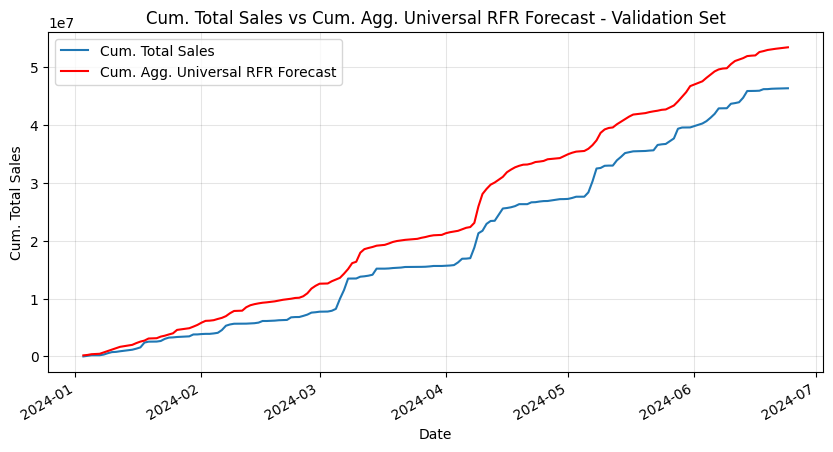

In [21]:
plt.figure(figsize=(10, 5))
y_universal_val_true_total.cumsum().plot(label='Cum. Total Sales')
y_universal_val_pred_total.cumsum().plot(label='Cum. Agg. Universal RFR Forecast', color='red')
plt.legend()
plt.title('Cum. Total Sales vs Cum. Agg. Universal RFR Forecast - Validation Set')
plt.xlabel('Date')
plt.ylabel('Cum. Total Sales')
plt.grid(c='k', alpha=0.1)
plt.show()

In [22]:
y_universal_test_pred = best_rfr_model.predict(X_universal['test'].values)
y_universal_test_pred = pd.Series(y_universal_test_pred, index=y_universal['test'].index)

In [23]:
print(f'Universal RFR Model Evaluation - Test Set:')
print(f"MAE: {mean_absolute_error(y_universal['test'].values, y_universal_test_pred.values):.2f}")
print(f"RMSE: {root_mean_squared_error(y_universal['test'].values, y_universal_test_pred.values):.2f}")
print(f"R2: {r2_score(y_universal['test'].values, y_universal_test_pred.values):.2f}")

Universal RFR Model Evaluation - Test Set:
MAE: 2620.07
RMSE: 10671.43
R2: 0.11


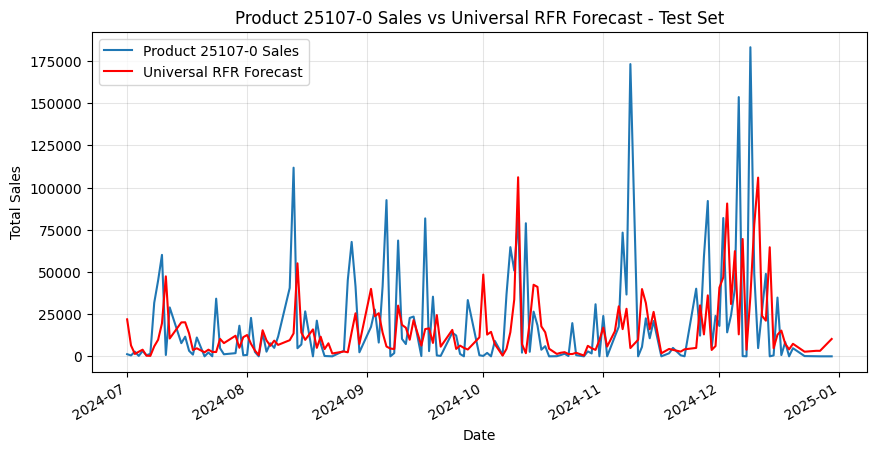

Universal RFR Model Evaluation for Product 25107-0 - Test Set:
MAE: 19622.40
RMSE: 33994.66
R2: -0.15


In [24]:
plt.figure(figsize=(10, 5))
_y_test = y_universal['test'].xs(ID_PRODUTO, level='id_produto')
_y_test_pred = y_universal_test_pred.xs(ID_PRODUTO, level='id_produto')
_y_test.plot(label=f'Product {ID_PRODUTO} Sales')
_y_test_pred.plot(label='Universal RFR Forecast', color='red')
plt.legend()
plt.title(f'Product {ID_PRODUTO} Sales vs Universal RFR Forecast - Test Set')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(c='k', alpha=0.1)
plt.show()

print(f'Universal RFR Model Evaluation for Product {ID_PRODUTO} - Test Set:')
print(f'MAE: {mean_absolute_error(_y_test.values, _y_test_pred.values):.2f}')
print(f'RMSE: {root_mean_squared_error(_y_test.values, _y_test_pred.values):.2f}')
print(f'R2: {r2_score(_y_test.values, _y_test_pred.values):.2f}')

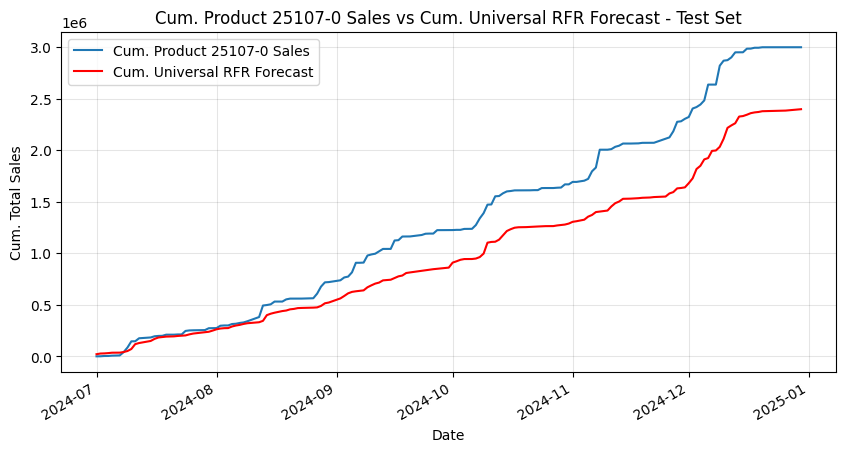

In [25]:
plt.figure(figsize=(10, 5))
_y_test = y_universal['test'].xs(ID_PRODUTO, level='id_produto')
_y_test_pred = y_universal_test_pred.xs(ID_PRODUTO, level='id_produto')
_y_test.cumsum().plot(label=f'Cum. Product {ID_PRODUTO} Sales')
_y_test_pred.cumsum().plot(label='Cum. Universal RFR Forecast', color='red')
plt.legend()
plt.title(f'Cum. Product {ID_PRODUTO} Sales vs Cum. Universal RFR Forecast - Test Set')
plt.xlabel('Date')
plt.ylabel('Cum. Total Sales')
plt.grid(c='k', alpha=0.1)
plt.show()

In [26]:
y_universal_test_pred_total = y_universal_test_pred.groupby('data').sum()
y_universal_test_true_total = y_universal['test'].groupby('data').sum()

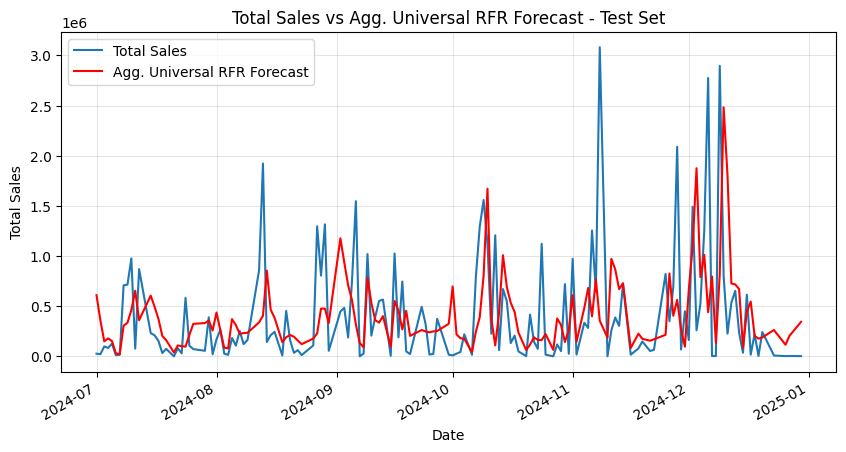

Agg. Universal RFR Model Evaluation - Test Set:
RMSE: 576663.05
MAE: 369957.00
R2: -0.06


In [28]:
plt.figure(figsize=(10, 5))
y_universal_test_true_total.plot(label='Total Sales')
y_universal_test_pred_total.plot(label='Agg. Universal RFR Forecast', color='red')
plt.legend()
plt.title('Total Sales vs Agg. Universal RFR Forecast - Test Set')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(c='k', alpha=0.1)
plt.show()

print('Agg. Universal RFR Model Evaluation - Test Set:')
print(f"RMSE: {root_mean_squared_error(y_universal_test_true_total.values, y_universal_test_pred_total.values):.2f}")
print(f"MAE: {mean_absolute_error(y_universal_test_true_total.values, y_universal_test_pred_total.values):.2f}")
print(f"R2: {r2_score(y_universal_test_true_total.values, y_universal_test_pred_total.values):.2f}")

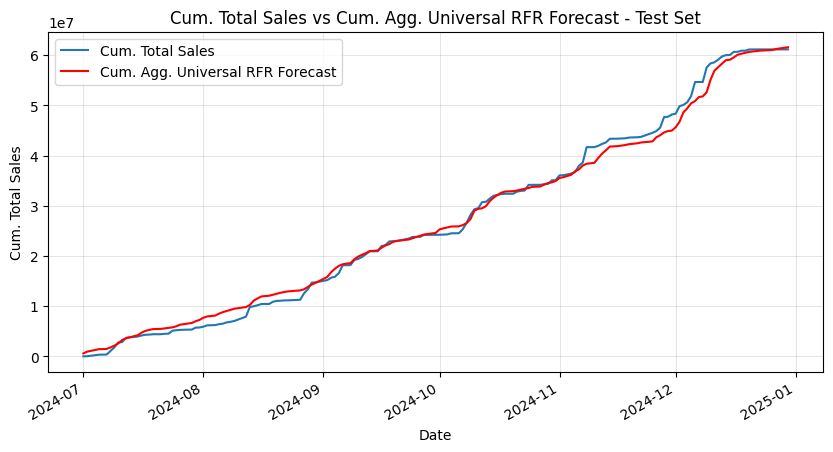

In [29]:
plt.figure(figsize=(10, 5))
y_universal_test_true_total.cumsum().plot(label='Cum. Total Sales')
y_universal_test_pred_total.cumsum().plot(label='Cum. Agg. Universal RFR Forecast', color='red')
plt.legend()
plt.title('Cum. Total Sales vs Cum. Agg. Universal RFR Forecast - Test Set')
plt.xlabel('Date')
plt.ylabel('Cum. Total Sales')
plt.grid(c='k', alpha=0.1)
plt.show()

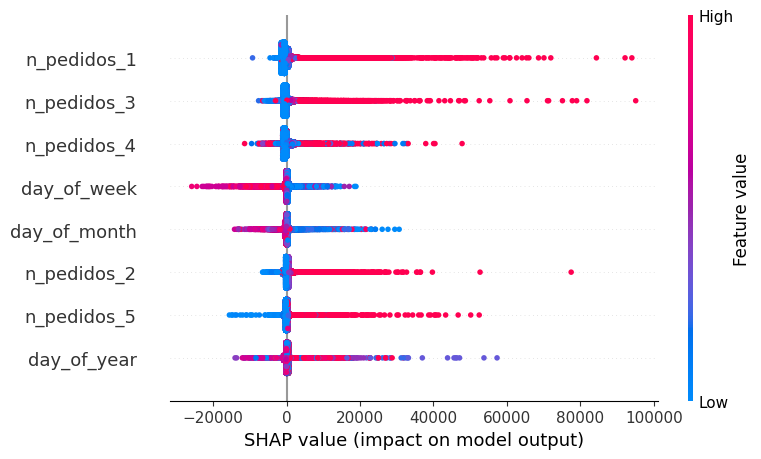

In [81]:
explainer = shap.TreeExplainer(best_rfr_model)
shap_values = explainer.shap_values(X_universal['train'].values)
shap.summary_plot(shap_values, X_universal['train'].values, feature_names=X_universal['train'].columns)

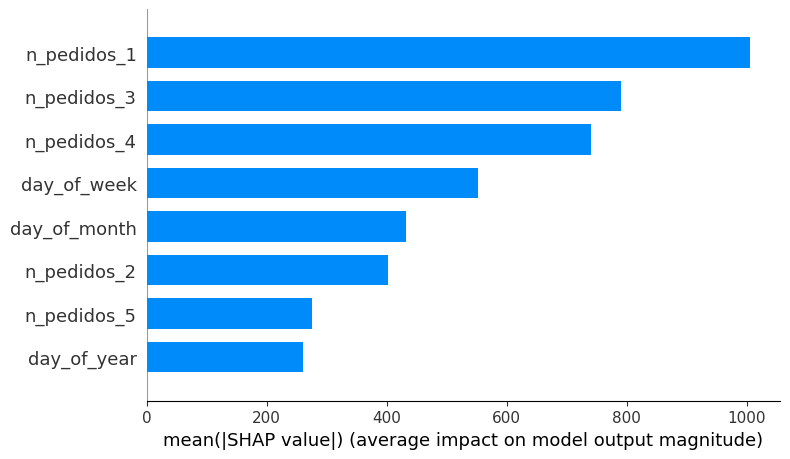

In [82]:
shap.summary_plot(shap_values, X_universal['train'].values, feature_names=X_universal['train'].columns, plot_type="bar")

## Multivariate RFR Model

In [30]:
# y_universal_train_unstacked = y_universal['train'].unstack()
# corrwith_prod = (
#     y_universal_train_unstacked.drop(columns=[ID_PRODUTO])
#     .corrwith(y_universal_train_unstacked[ID_PRODUTO], method='spearman')
#     .dropna().sort_values()
# )
# corrwith_prod

In [31]:
# corr_threshold = 0.80
# id_to_generate_features = corrwith_prod[corrwith_prod.abs() > corr_threshold].index
# id_to_generate_features = id_to_generate_features.union([ID_PRODUTO])
# id_to_generate_features

In [32]:
# X_mult = {}
# y_mult = {}
# for period in ['train', 'val', 'test']:
#     _df_split_period = df_split[period].loc[pd.IndexSlice[:, id_to_generate_features], :].unstack()
#     X_mult[period] = _df_split_period.shift(range(1, 4))
#     X_mult[period]['day_of_week'] = X_mult[period].index.dayofweek
#     X_mult[period]['day_of_month'] = X_mult[period].index.day
#     X_mult[period]['day_of_year'] = X_mult[period].index.dayofyear
#     X_mult[period] = X_mult[period].dropna()
#     y_mult[period] = df_split[period]['n_pedidos'].xs(ID_PRODUTO, level='id_produto').reindex(
#         X_mult[period].index,
#     )

In [33]:
# X_mult['train']

In [34]:
# y_mult['train']

In [35]:
# param_grid = [
#     {
#         'n_estimators': n_estimators,
#         'max_depth': max_depth,
#         'min_samples_split': min_samples_split,
#         'min_samples_leaf': min_samples_leaf,
#         'random_state': cfg['random_state'],
#     }
#     for n_estimators in [50, 100, 200]
#     for max_depth in [10, None]
#     for min_samples_split in [2, 5]
#     for min_samples_leaf in [1, 2]
# ]
# len(param_grid)

In [36]:
# rfr_results = []
# best_rfr_r2 = -float('inf')
# for params in tqdm(param_grid):
#     rfr = RandomForestRegressor(**params)
#     rfr.fit(X_mult['train'].values, y_mult['train'].values)
#     y_val_pred = rfr.predict(X_mult['val'].values)
#     mae = mean_absolute_error(y_mult['val'].values, y_val_pred)
#     rmse = root_mean_squared_error(y_mult['val'].values, y_val_pred)
#     r2 = r2_score(y_mult['val'].values, y_val_pred)
#     if best_rfr_r2 < r2:
#         best_rfr_r2 = r2
#         best_params = params
#         best_rfr_model = rfr
#     rfr_results.append({
#         **params,
#         'mae': mae,
#         'rmse': rmse,
#         'r2': r2,
#     })
# rfr_results_df = pd.DataFrame(rfr_results)

In [37]:
# best_rfr_r2

In [38]:
# best_params

In [39]:
# rfr_results_df.sort_values('r2')